In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def sigmoid_formula(x,L,Int):
    L=L
    K=1
    e=np.exp(1)
    a=-1
    Int=Int
    y=(L/(1+K*e**(a*x)))-Int
    return y

In [4]:
df_sample=pd.read_csv('df_sample.csv',sep=',')
    #formating the date column
df_sample.Date=pd.to_datetime(df_sample.Date, format="%Y-%m-%d")

In [5]:
df_sample.Cus_ID.unique()

array([ 8568,  8611,  8629,  8741,  8775,  8843,  8963,  8985,  9175,
        9370,  9480,  9658,  9701,  9714,  9751,  9797,  9827,  9857,
        9881, 10174, 10204, 10224, 10289, 10542, 10563, 10683, 10741,
       11041, 11065, 11166, 11578, 11667, 11674, 11825, 12028, 12111,
       12143, 12146, 12303, 12331, 12468, 12653, 12822, 12909, 12987,
       12993, 13026, 13095, 13114, 13180, 13310, 13929, 14189, 14484,
       14500, 14507, 14508, 14567, 14599, 14610, 14844, 15070, 15078,
       15176, 15249, 15269, 15447, 15743, 15841, 16236, 16355, 16600,
       16689, 17196, 17300, 17440, 17500, 17528, 17627, 17827, 17852,
       17861, 17891, 17904, 17925, 17931, 17980, 18045, 18050, 18059,
       18071, 18083, 18110, 18117, 18123, 18127, 18128, 18137, 18146,
       18161, 18189, 18224, 18231, 18262, 18275, 18290, 18291, 18316,
       18354, 18360, 18389, 18395, 18402, 18414, 18455, 18472, 18475,
       18488, 18489, 18502, 18523, 18609, 18625, 18695, 18712, 18719,
       18735, 18746,

In [6]:
#Experimentation
def dataframe_generation_scores(ID,inicio,fin):  #inidate,finaldate
    df_bla=df_sample[(df_sample.Time_vector>=inicio)&(df_sample.Time_vector<=fin)]
    inidate=str(df_bla.iloc[0]['Date'])
    finaldate=str(df_bla.iloc[-1]['Date'])
    
    when=inidate
    inidate=datetime.strptime(when,'%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
    
    when=finaldate
    finaldate=datetime.strptime(when,'%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
    
    df_sample_1=df_sample[df_sample.Cus_ID==ID]
    Start_date=datetime.strptime(inidate, '%Y-%m-%d')
    End_date=datetime.strptime(finaldate, '%Y-%m-%d')  

    datex=Start_date
    datelist=list()
    while datex<=End_date: #creating base time dataframe
        datelist.append(datex)
        datex+= timedelta(days=1)  
    datelist
    Dates={'Dates':datelist} 
    Dates=pd.DataFrame(Dates)

    #merging the base date dataframe and the sample dataframe
    df=pd.merge(left=Dates,right=df_sample_1,how='outer',left_on='Dates', right_on='Date').drop(columns='Date')
    df=df.rename(columns={'Schedule':'Due_Payment'})
    df=df[df.Dates.dt.dayofweek <= 5] #removing sundays

    # using percentage of payment modified with 0 due payment = previous duepayment
    for row in df.index:
        if df.loc[row,'Due_Payment']>0:
            previous_due_payment=df.loc[row,'Due_Payment']
    
        if df.loc[row,'Due_Payment']>0:
            df.loc[row,'percentage_payment']=df.loc[row,'payment']/df.loc[row,'Due_Payment']
        else:
            df.loc[row,'percentage_payment']=df.loc[row,'payment']/previous_due_payment
        
        df.loc[row,'previous_due_payment']=previous_due_payment
        
        if  np.isnan(df.loc[row,'percentage_payment']): #correcting empty spaces with a constant penalty
            df.loc[row,'percentage_payment']=0.2
            
    # correction in case of inactivity
    for row_main in df.index:
        if np.isnan(df.loc[row_main,'Due_Payment']):
            for row_pivot in df.loc[row_main+1:].index:
                if ~np.isnan(df.loc[row_pivot,'Due_Payment']):
                    break
                elif row_pivot-row_main>5:
                    df.loc[row_main:row_pivot,'percentage_payment']=0.9
    
    #filtering
    df=df[['Dates','Time_vector', 'Cus_ID', 'Due_Payment', 'payment', 'diff','previous_due_payment','percentage_payment']]

    ## creating the control of extreme values
    for row in df.index:
        if df.loc[row,'percentage_payment']>1:
            df.loc[row,'transformed_percentage']=sigmoid_formula(df.loc[row,'percentage_payment'],3,1)
        else:
            df.loc[row,'transformed_percentage']=df.loc[row,'percentage_payment']

    #selection of the columns
    df_selected=df[['Dates','Cus_ID','Due_Payment','payment','previous_due_payment','percentage_payment','transformed_percentage']]
    
    def score_base(x):
        return abs((x-1)*100)

    df_selected['score_base']=np.vectorize(score_base)(df_selected['transformed_percentage'])
    df_selected=df_selected.reset_index(drop=True)
    df_selected=df_selected.reset_index().rename(columns={'index':'time_vector_days'})
    #creating a cumulative sum procedure
    column='score_base'

    def vector_weights_cumsum(time):
        Number_of_days=time
        top=0.8 # parametros
        botton=0 # parametros
        d_rate=0.2 # parametros
        top_dur=6 # parametros

        l_numbers=[top]
        t=1
        while t<=Number_of_days:
            if t >=Number_of_days:
                break

            if t%top_dur==0:
                l_numbers.append(l_numbers[t-1]-d_rate)
            else:
                l_numbers.append(l_numbers[t-1])
            t+=1

        l_numbers=[botton if b<=botton else b for b in l_numbers]
        l_numbers=[i for i in l_numbers if i >= (botton+d_rate)]
        l_numbers=[a/sum(l_numbers) for a in l_numbers]
        return l_numbers

    for row in df_selected.index:
        list_weights=vector_weights_cumsum(row+1)
        if ((row)-len(list_weights))<=0:
            list_rates=list(df_selected.iloc[0:(row+1)][column])
            list_rates.reverse()
            cum_score=np.nansum([(lambda x:x[0]*x[1])(x) for x in list(zip(list_weights,list_rates))])
            df_selected.loc[row,'smooth_average_score']=cum_score
        else:
            list_rates=list(df_selected.iloc[((row)-len(list_weights)):(row+1)][column])
            list_rates.reverse()
            cum_score=np.nansum([(lambda x:x[0]*x[1])(x) for x in list(zip(list_weights,list_rates))])
            df_selected.loc[row,'smooth_average_score']=cum_score
            
    return (df_selected,list_weights,list_rates)


In [7]:
[18071, 18083, 18110, 18117, 18123, 18127, 18128, 18137, 18146]
df_selected=dataframe_generation_scores(17891,10,60)[0][1:]
dataframe_generation_scores(17891,10,60)[1]

[0.0666666666666667,
 0.0666666666666667,
 0.0666666666666667,
 0.0666666666666667,
 0.0666666666666667,
 0.0666666666666667,
 0.050000000000000024,
 0.050000000000000024,
 0.050000000000000024,
 0.050000000000000024,
 0.050000000000000024,
 0.050000000000000024,
 0.03333333333333335,
 0.03333333333333335,
 0.03333333333333335,
 0.03333333333333335,
 0.03333333333333335,
 0.03333333333333335,
 0.016666666666666677,
 0.016666666666666677,
 0.016666666666666677,
 0.016666666666666677,
 0.016666666666666677,
 0.016666666666666677]

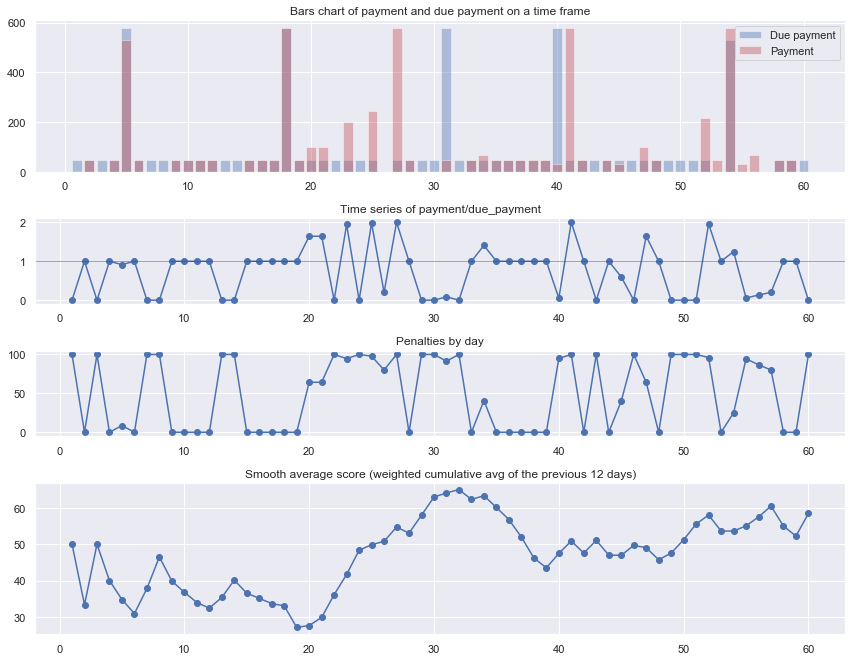

In [8]:
fig = plt.figure(figsize=(12,10))

#gridspec.GridSpec(9,9)

axes0 = plt.subplot2grid((11, 1), (0, 0), rowspan=3)
axes1 = plt.subplot2grid((11, 1), (3, 0),rowspan=2)
axes2 = plt.subplot2grid((11, 1), (5, 0),rowspan=2)
axes3 = plt.subplot2grid((11, 1), (7, 0),rowspan=3)


axes0.bar(df_selected.time_vector_days.fillna(0),df_selected.Due_Payment.fillna(0),color='b',label='Due payment',alpha=0.4)
axes0.bar(df_selected.time_vector_days.fillna(0),df_selected.payment.fillna(0),color='r',label='Payment',alpha=0.4)
axes0.legend()

#axes1.plot(df_selected.time_vector_days.fillna(0),df_selected.payment.fillna(0)-df_selected.Due_Payment.fillna(0))
axes1.plot(df_selected.time_vector_days.fillna(0),df_selected['transformed_percentage'].fillna(0),marker='o')
axes2.plot(df_selected.time_vector_days.fillna(0),df_selected['score_base'].fillna(0),marker='o')
axes3.plot(df_selected.time_vector_days.fillna(0),df_selected['smooth_average_score'].fillna(0),marker='o')
axes0.title.set_text('Bars chart of payment and due payment on a time frame')
#axes1.title.set_text('Difference between due payment and payment')
axes1.title.set_text('Time series of payment/due_payment')
axes2.title.set_text('Penalties by day')
axes3.title.set_text('Smooth average score (weighted cumulative avg of the previous 12 days)')
axes1.axhline(y=1,c="red",linewidth=0.5)

plt.tight_layout()
plt.savefig('plot_tesis1.jpg')

## Machine learning section

In [9]:
#initial ID= 18110  arima (2,1,2)
#other IDS=17891  arima (2,2,0)

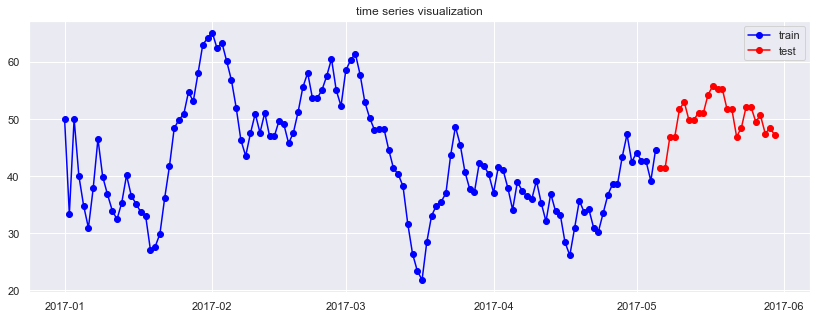

In [10]:
ID=17891
n_days=25 #for test set
data=(dataframe_generation_scores(ID=ID,inicio=10,fin=150)[0][1:][['time_vector_days','smooth_average_score']])

#formating dates (taking as default begining 01/01/2017 for all customers)
data.index=pd.date_range(start='1/1/2017', periods=len(data.time_vector_days))
data['value']=data.smooth_average_score
data=data.drop(columns=['time_vector_days','smooth_average_score'])

plt.figure(figsize=(14,5))
plt.plot(data[:-n_days],color='blue',marker='o',label='train')
plt.plot(data[-n_days:], color='red',marker='o',label='test')
plt.legend()
plt.title('time series visualization')
plt.savefig('plot_tesis2.jpg')

In [11]:
print(len(data[:-n_days]),len(data[-n_days:]))


125 25


#### Winter's method

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [13]:
data_wm=data.copy()

n_train=len(data_wm)-n_days
train=data_wm[0:n_train]
#train=train.loc['2017-03-15':] 
test=data_wm[n_train:]

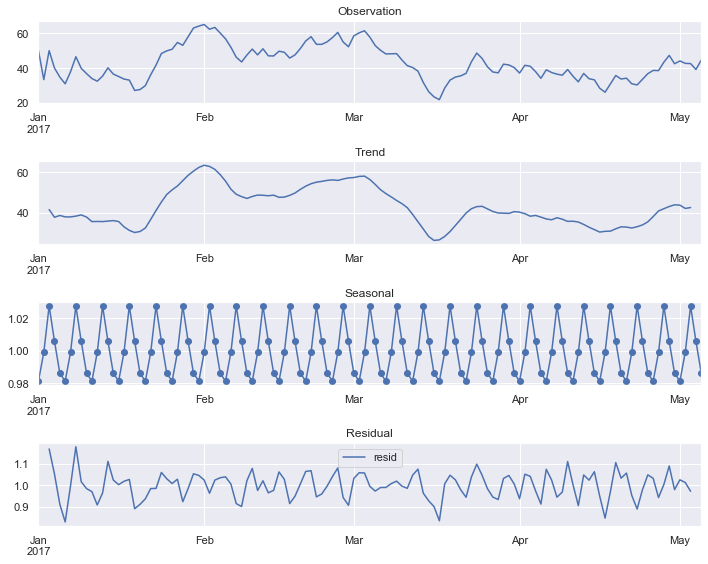

In [14]:
result = seasonal_decompose(train, model='multiplicative',freq=5)
#result.plot()
#plt.show()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(10,8))
result.observed.plot(ax=ax0,title='Observation')
result.trend.plot(ax=ax1,title='Trend')
result.seasonal.plot(ax=ax2,marker='o',title='Seasonal')
result.resid.plot(ax=ax3, title='Residual')
plt.legend()
plt.tight_layout()
plt.savefig('plot_tesis3.jpg')

In [15]:
model_ES = ExponentialSmoothing(train, trend='mul',seasonal='mul', seasonal_periods=5).fit()  #seasonal periods an be 7
pred_HW = model_ES.predict(start=test.index[0], end=test.index[-1])
pred_HW=pred_HW.to_frame().rename(columns={0:'Predictions_HW'})
pred_HW=pred_HW.iloc[:,0]

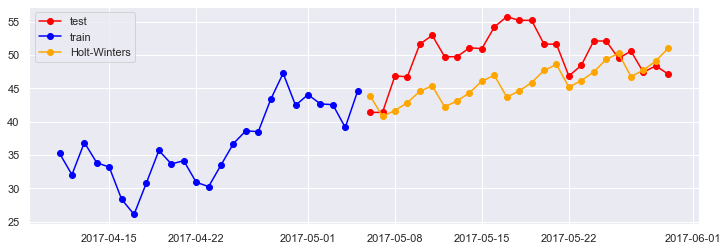

In [16]:
## ploting results
plt.figure(figsize=(12,4))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(pred_HW.index, pred_HW, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis4.jpg')

In [17]:
##rolling prediction for holt-winters
def rolling_HW(seasonal_periods=7): #the arguments are the hyper parameters
    history= [x for x in train.value]
    predictions = list()
    for t in range(len(test)):
        model_ES=ExponentialSmoothing(history, trend='mul',seasonal='mul', seasonal_periods=seasonal_periods).fit()
        pred_HW = model_ES.predict()
        yhat = pred_HW[0]
        predictions.append(yhat)
        obs = test.values[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(test, predictions)
    rolling_predictions=predictions
    rolling_predictions_HW=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['rolling_predictions_HW']) # converting to dataframe
    rolling_predictions_HW=rolling_predictions_HW.iloc[:,0] #converting to pandas series
    return  rolling_predictions_HW, error

In [18]:
rolling_predictions_HW=rolling_HW()[0]

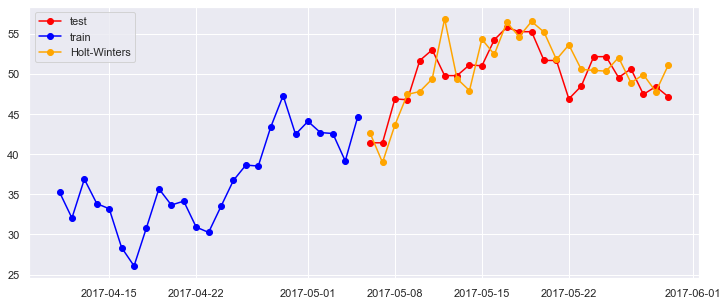

In [19]:
plt.figure(figsize=(12,5))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(rolling_predictions_HW, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis5.jpg')

##### cross validation of the hyperparameter # seasonal days

In [20]:
### cross validation of the hyperparameter # seasonal days
list_seasonal_days=[3,5,7,9,12,15,18,20,22,25]
MAE_list=[]
for i in list_seasonal_days:
    mae_hw=rolling_HW(seasonal_periods=i)[1]
    MAE_list.append(mae_hw)

In [21]:
pd.DataFrame(data=MAE_list,index=list_seasonal_days,columns=['MAE'])

,MAE
3,2.193530
5,2.787739
7,2.420879
9,2.273855
12,2.747026
15,3.332956
18,3.753334
20,3.725999
22,2.162844
25,3.902878


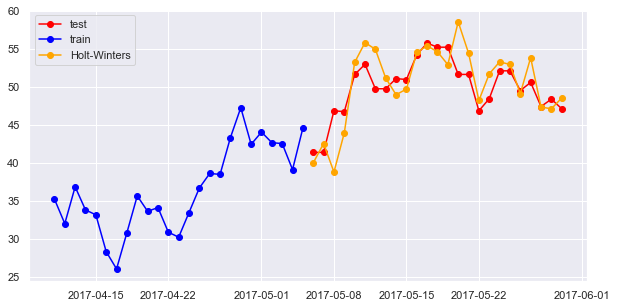

In [22]:
## using the new seasonal periods
rolling_predictions_HW_tunned=rolling_HW(seasonal_periods=22)[0]
plt.figure(figsize=(10,5))
plt.plot(test,label='test',marker='o',color='red')
plt.plot(train[100:],label='train', marker='o',color='blue')
plt.plot(rolling_predictions_HW_tunned, label='Holt-Winters',marker='o',color='orange')
plt.legend(loc='best')
plt.savefig('plot_tesis6.jpg')

#### ARMA model

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.tsa.arima_model import ARIMA,ARMAResults 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

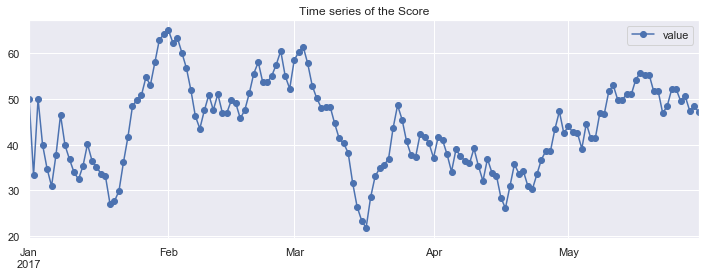

In [24]:
data.plot(figsize=(12,4),marker='o',title='Time series of the Score')

In [25]:
## splitting data, trainning and test
## specification from training
data_ts=data.copy()

n_topredict= n_days  #nnumber of days that will be removed 

n_train=len(data_ts)-n_topredict
train=data_ts[0:n_train]
#train=train.loc['2017-03-10':]  #in case of cut of the training data
test=data_ts[n_train:]

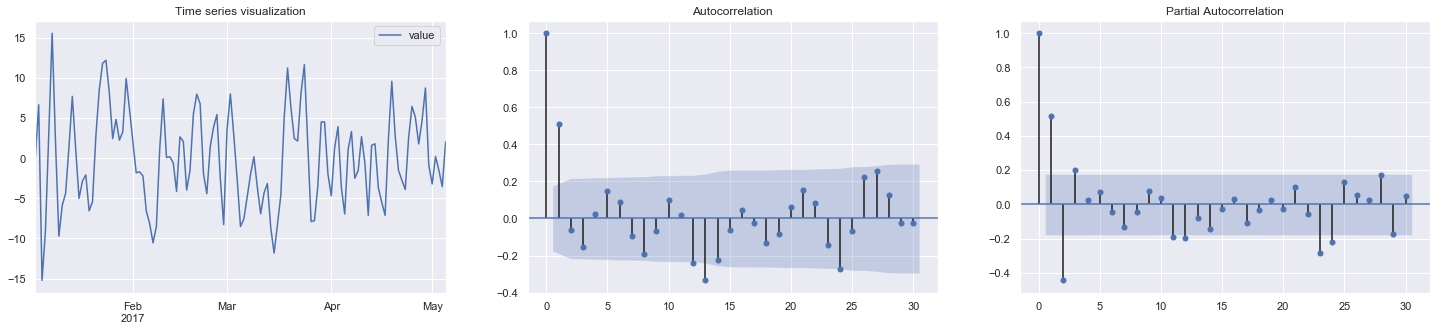

<Figure size 432x288 with 0 Axes>

In [26]:
sample=train.diff(periods=2)[2:]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
sample.plot(ax=axes[0],title='Time series visualization')
plot_acf(sample,lags=30,ax=axes[1])
plot_pacf(sample,lags=30,ax=axes[2]) # arima (p4,q4) 
plt.show()
plt.savefig('plot_tesis7.jpg')

In [27]:
if adfuller(sample)[1]>0.05:
    print('pvalue:'+str(adfuller(sample)[1])+' data is non stationary')# pvalue
else:
    print('pvalue:'+str(adfuller(sample)[1])+'data is weakly stationary')

pvalue:0.0014412060291517266data is weakly stationary


In [28]:
# model looks good for the three first predictions
my_order = (3,2,0)
#my_seasonal_order = (0, 0, 0, 0)
#model_arma=SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
model_arma=ARIMA(train, order=my_order)
model_arma_fit=model_arma.fit(disp=0)

print(model_arma_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  123
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -365.030
Method:                       css-mle   S.D. of innovations              4.685
Date:                Tue, 16 Jun 2020   AIC                            740.059
Time:                        14:35:54   BIC                            754.120
Sample:                    01-03-2017   HQIC                           745.771
                         - 05-05-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0440      0.161      0.273      0.785      -0.272       0.360
ar.L1.D2.value    -0.7238      0.090     -8.027      0.000      -0.901      -0.547
ar.L2.D2.value    -0.4838      0.105

In [29]:
#initial prediction 
pred_start_date = test.index[0]
pred_end_date = test.index[-1]

predictions=model_arma_fit.forecast(len(test))
predictions_arima=pd.DataFrame(data=predictions[0],index=test.index,columns=['Predictions_Arima'])
predictions_arima=predictions_arima.iloc[:,0]

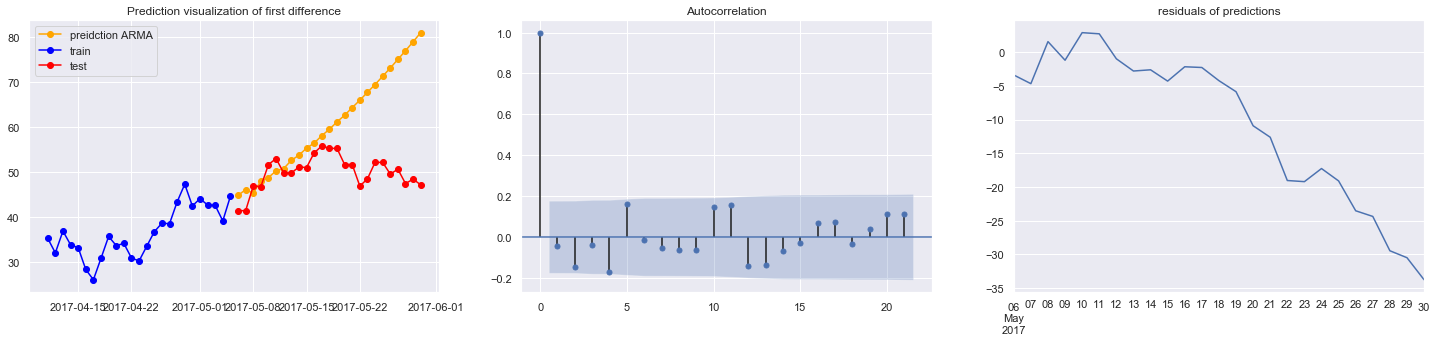

<Figure size 432x288 with 0 Axes>

In [30]:
residuals=test.iloc[:,0]-predictions_arima

#Results
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
plot_acf(model_arma_fit.resid,ax=axes[1]) #auc of residuals

axes[0].plot(predictions_arima,color='orange',label='preidction ARMA',marker='o')
axes[0].plot(train[100:],color='blue',label='train',marker='o')
axes[0].plot(test,label='test',color='red',marker='o')
axes[0].title.set_text('Prediction visualization of first difference')
axes[0].legend(loc="best")

residuals.plot(ax=axes[2], title='residuals of predictions')

plt.show()
plt.savefig('plot_tesis8.jpg')

In [31]:
#acorr_ljungbox(res.resid, lags=[10], return_df=True)
ljb_test=acorr_ljungbox(model_arma_fit.resid, lags=[1,2,3,4,5,10,15,20,25,30], return_df=True)
def test_ho_jb(x):
    if x>0.05:
        return 'Do not reject H0 -> no autocorr at this lag'
    else:
        return 'Reject H0 -> autocorr at this lag'

ljb_test['result']=ljb_test.lb_pvalue.apply(test_ho_jb)
ljb_test

,lb_stat,lb_pvalue,result
1,0.258702,0.611013,Do not reject H0 -> no autocorr at this lag
2,3.105536,0.211661,Do not reject H0 -> no autocorr at this lag
3,3.305986,0.346810,Do not reject H0 -> no autocorr at this lag
4,7.206697,0.125360,Do not reject H0 -> no autocorr at this lag
5,10.542591,0.061242,Do not reject H0 -> no autocorr at this lag
10,14.885930,0.136276,Do not reject H0 -> no autocorr at this lag
15,24.651761,0.054820,Do not reject H0 -> no autocorr at this lag
20,28.309383,0.102276,Do not reject H0 -> no autocorr at this lag
25,39.251295,0.034758,Reject H0 -> autocorr at this lag
30,48.477728,0.017755,Reject H0 -> autocorr at this lag


In [32]:
def rolling_arma(order_arma=my_order):
    history = [x for x in train.value]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order_arma)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0][0]
        predictions.append(yhat)
        obs = test.values[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(test, predictions)
    aic=model_fit.aic
    rolling_predictions=predictions
    predictions_y_arima=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['predictions_y_arima'])
    predictions_rolling_arima=predictions_y_arima.iloc[:,0]
    rolling_residuals=pd.DataFrame(data=np.ravel(predictions_rolling_arima.values-np.ravel(test.values)),
                                   index=test.index,columns=['Residuals'])
    return (predictions_rolling_arima,error,aic,rolling_residuals)

In [33]:
predictions_rolling_arima=rolling_arma(order_arma=my_order)[0]
rolling_residuals=rolling_arma(order_arma=my_order)[3]

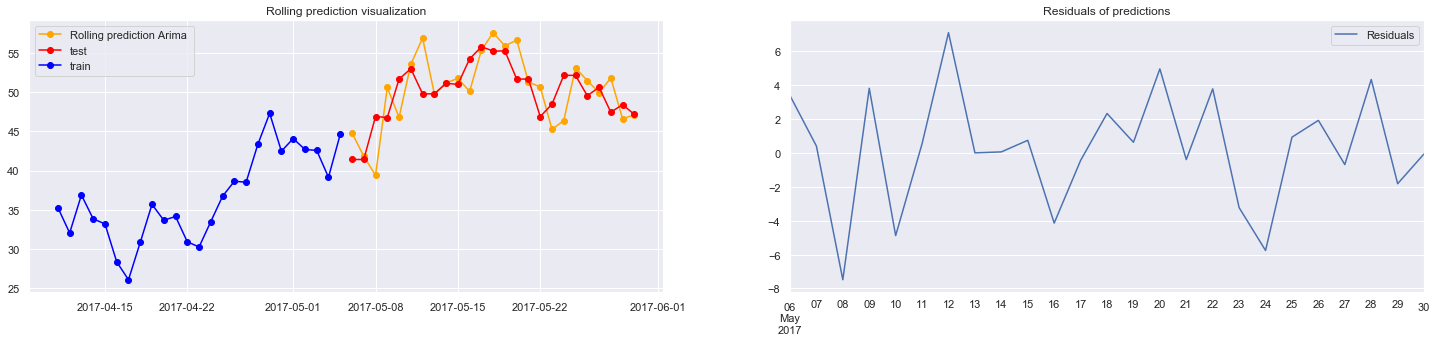

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(25,5))
axes[0].plot(predictions_rolling_arima,color='orange',marker='o',label='Rolling prediction Arima ')
axes[0].plot(test,color='red',marker='o', label='test')
axes[0].plot(train[100:],color='blue',marker='o',label='train')
axes[0].title.set_text('Rolling prediction visualization')
axes[0].legend(loc="best")

rolling_residuals.plot(ax=axes[1],title='Residuals of predictions')
plt.savefig('plot_tesis9.jpg')

##### Cross validation of the hyperparameter # different orders arima(pdq) (tuples format)

In [35]:
list_esp=[(3,2,0),(2,2,0),(1,2,0),(0,2,0)]
MAE_list=[]
AIC_list=[]
for i in list_esp:
    mae_arima=rolling_arma(order_arma=i)[1]
    aic_arima=rolling_arma(order_arma=i)[2]
    MAE_list.append(mae_arima)
    AIC_list.append(aic_arima)
data_metrics={'MAE':MAE_list,'AIC':AIC_list}
pd.DataFrame(data=data_metrics,index=list_esp)

,MAE,AIC
"(3, 2, 0)",2.556550,870.724730
"(2, 2, 0)",2.458856,884.514750
"(1, 2, 0)",2.665087,894.694691
"(0, 2, 0)",3.644299,929.609564


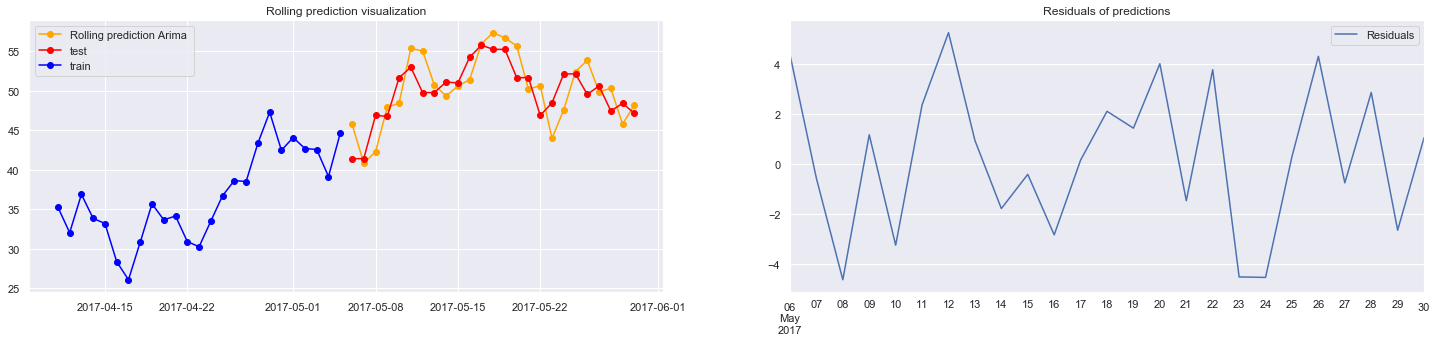

In [36]:
predictions_rolling_arima_tunned=rolling_arma(order_arma=(2,2,0))[0]
rolling_residuals=rolling_arma(order_arma=(2,2,0))[3]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(25,5))
axes[0].plot(predictions_rolling_arima_tunned,color='orange',marker='o',label='Rolling prediction Arima ')
axes[0].plot(test,color='red',marker='o', label='test')
axes[0].plot(train[100:],color='blue',marker='o',label='train')
axes[0].title.set_text('Rolling prediction visualization')
axes[0].legend(loc="best")

rolling_residuals.plot(ax=axes[1],title='Residuals of predictions')
plt.savefig('plot_tesis10.jpg')

### Support vector machine

In [37]:
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.base import clone

In [38]:
data_svm=data.copy()
#data_svm['day_month_vector']=data_svm.index.day
data_svm['time_vector']=range(1,len(data_svm)+1)

data_svm.head()

,value,time_vector
2017-01-01,50.000000,1
2017-01-02,33.333333,2
2017-01-03,50.000000,3
2017-01-04,40.000000,4
2017-01-05,34.770115,5


In [39]:
n_topredict=n_days
n_train=len(data_svm)-n_topredict
train=data_svm[0:n_train]
test=data_svm[n_train:]

X_train=train.iloc[:,1:].values
Y_train=np.array(train.value).reshape(-1, 1)
Y_train=np.ravel(Y_train)

X_test=test.iloc[:,1:].values
Y_test=np.array(test.value).reshape(-1, 1)
Y_test=np.ravel(Y_test)

In [40]:
## time and value are given as arrays
svr_rfb=SVR(kernel='rbf',C=5,gamma=0.1,epsilon=0.1)  #linear kernel overfits
svr_rfb.fit(X_train,Y_train)

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [41]:
svr_prediction=pd.DataFrame(data=svr_rfb.predict(X_test),index=test.index,columns=['SVR-prediction'])

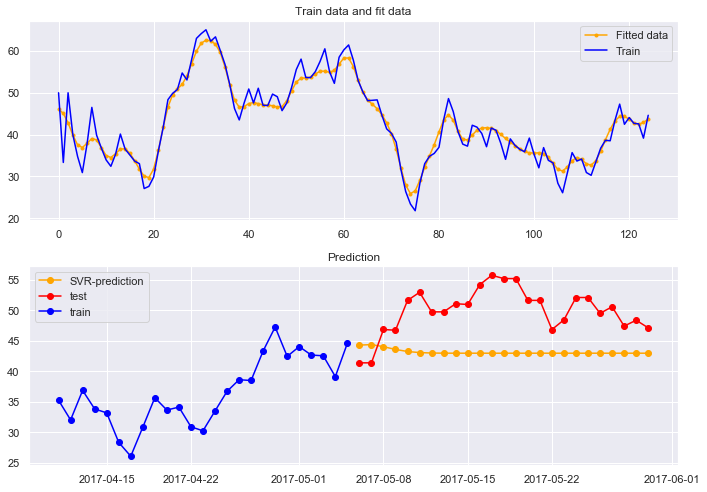

<Figure size 432x288 with 0 Axes>

In [42]:
## fitting the model into the train data
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,7))

axes[0].plot(svr_rfb.predict(X_train),marker='.',color='orange',label='Fitted data')
axes[0].plot(Y_train,color='blue',label='Train')
axes[0].legend()
axes[0].title.set_text('Train data and fit data')

axes[1].plot(svr_prediction,color='orange',marker='o',label='SVR-prediction')
axes[1].plot(test['value'],color='red',marker='o',label='test')
axes[1].plot(train['value'][100:],color='blue',marker='o',label='train')
axes[1].legend()
axes[1].title.set_text('Prediction')

plt.tight_layout()
plt.show()
plt.savefig('plot_tesis11.jpg')

In [43]:
##rolling prediction
def rolling_prediction_SVR(C=5,gamma=0.1,epsilon=0.1):
    X_history= [x for x in list(np.ravel(X_train))]
    Y_history= [x for x in list(Y_train)]
    predictions = list()
    
    for t in range(len(Y_test)):
        #reshaping in numpy array
        X_history=np.array(X_history).reshape(-1,1)
        Y_history=np.array(Y_history)

        model_svr_rfb=SVR(kernel='rbf',C=C,gamma=gamma,epsilon=epsilon) #linear kernel overfits
        model_svr_rfb.fit(X_history,Y_history)
        pred_svr=model_svr_rfb.predict(np.array([[X_test[t][0]]]))
        yhat = pred_svr[0]
        predictions.append(yhat)

        #converting to list arrays
        X_history= [x for x in list(np.ravel(X_history))]
        Y_history= [x for x in list(Y_history)]

        obs_x = list(np.ravel(X_test))[t]
        obs_y = list(Y_test)[t]
        X_history.append(obs_x)
        Y_history.append(obs_y)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_absolute_error(list(Y_test), predictions)
    rolling_predictions=predictions
    rolling_predictions_SVR=pd.DataFrame(data=rolling_predictions,index=test.index,columns=['rolling_predictions_SVR']) # converting to dataframe
    rolling_predictions_SVR=rolling_predictions_SVR.iloc[:,0] #converting to pandas series
    return  rolling_predictions_SVR, error

In [44]:
rolling_predictions_SVR=rolling_prediction_SVR(C=5,gamma=0.1,epsilon=0.1)[0]

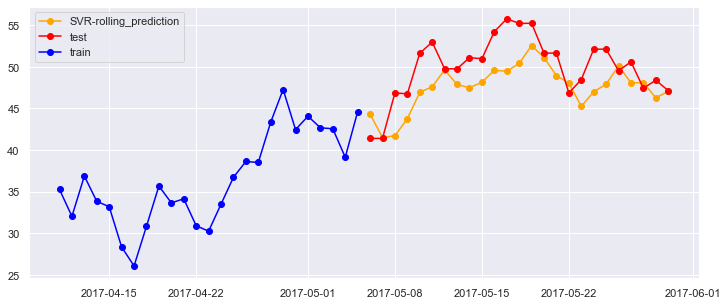

In [45]:
## fitting the model into the train data
plt.figure(figsize=(12,5))
plt.plot(rolling_predictions_SVR,color='orange',marker='o',label='SVR-rolling_prediction')
plt.plot(test['value'],color='red',marker='o',label='test')
plt.plot(train['value'][100:],color='blue',marker='o',label='train')
plt.legend()
plt.savefig('plot_tesis12.jpg')
plt.show()


##### Cross validation

In [46]:
C_list=[1,5,10,15,20,25,30,40,50,100]
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

error_df_cv_svr=pd.DataFrame(index=C_list,columns=epsilon_list)
for i in C_list:
    for j in epsilon_list:
        mae=rolling_prediction_SVR(C=i,gamma=0.1,epsilon=j)[1]
        error_df_cv_svr.loc[i,j]=round(mae,2)
error_df_cv_svr

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
1,5.17,5.18,5.21,5.24,5.26,5.28,5.31,5.34,5.36
5,2.84,2.85,2.85,2.86,2.86,2.88,2.9,2.95,2.97
10,2.79,2.76,2.73,2.7,2.66,2.61,2.55,2.52,2.51
15,2.6,2.57,2.51,2.46,2.4,2.38,2.34,2.29,2.27
20,2.51,2.48,2.44,2.39,2.35,2.31,2.27,2.27,2.25
25,2.66,2.61,2.52,2.43,2.37,2.34,2.32,2.3,2.27
30,2.73,2.65,2.56,2.47,2.39,2.36,2.34,2.32,2.28
40,2.8,2.74,2.68,2.58,2.46,2.36,2.34,2.34,2.32
50,2.88,2.84,2.78,2.69,2.54,2.43,2.39,2.38,2.41
100,3.22,3.17,3.09,2.99,2.89,2.76,2.65,2.56,2.59


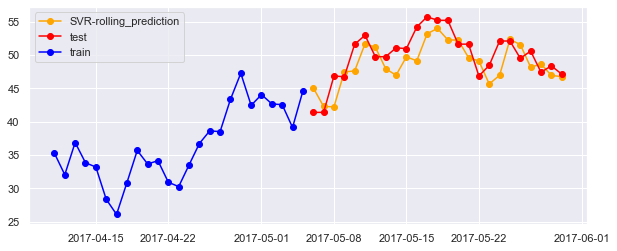

In [47]:
rolling_predictions_SVR_tunned=rolling_prediction_SVR(C=20,gamma=0.1,epsilon=0.9)[0]
## fitting the model into the train data
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions_SVR_tunned,color='orange',marker='o',label='SVR-rolling_prediction')
plt.plot(test['value'],color='red',marker='o',label='test')
plt.plot(train['value'][100:],color='blue',marker='o',label='train')
plt.legend()

plt.savefig('plot_tesis13.jpg')
plt.show()

### Recurrent  Neural Network

In [48]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
tf.__version__

'2.0.0-alpha0'

In [49]:
data_rnn=data.copy()
n_days_test=n_days
Train=data_rnn[:-n_days_test]
Test=data_rnn[-n_days_test:]

In [50]:
# fit scaler
scaler = MinMaxScaler()
scaler = scaler.fit(Train)

Train_scaled=scaler.transform(Train)
Test_scaled=scaler.transform(Test)

In [51]:
n_inputs= 20
n_features= 1

generator=TimeseriesGenerator(Train_scaled,Train_scaled,length=n_inputs,batch_size=1)

model = keras.Sequential()
model.add(keras.layers.LSTM(units=150,activation='relu',input_shape=(n_inputs,n_features)))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_absolute_error',optimizer='adam')

In [52]:
hist_model=model.fit_generator(generator,epochs=30,verbose=0)

In [60]:
#model.save("model_good_ID_17891.h5")

In [53]:
#preparing data for training the X training
X_train_block=[]
for i in range(len(Train)-n_inputs):
    block=list(Train_scaled.reshape((-1)))[i:i+n_inputs]
    X_train_block.append(block)
X_train_block=np.array(X_train_block)
X_train_block=X_train_block.reshape((X_train_block.shape[0],X_train_block.shape[1],1))

pred=scaler.inverse_transform(model.predict(X_train_block))
fitted=pd.DataFrame(data=pred,index=Train[n_inputs:].index,columns=['fitted'])

In [54]:
#preidction of the test
pred_list=[]
batch=Train_scaled[-n_inputs:].reshape((1,n_inputs,n_features))
for i in range(n_days_test):
    pred_list.append(model.predict(batch)[0])
    batch=np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
predictions_LSTM=pd.DataFrame(scaler.inverse_transform(pred_list),index=Test.index,columns=['Predictions'])
predictions_LSTM=predictions_LSTM.iloc[:,0]

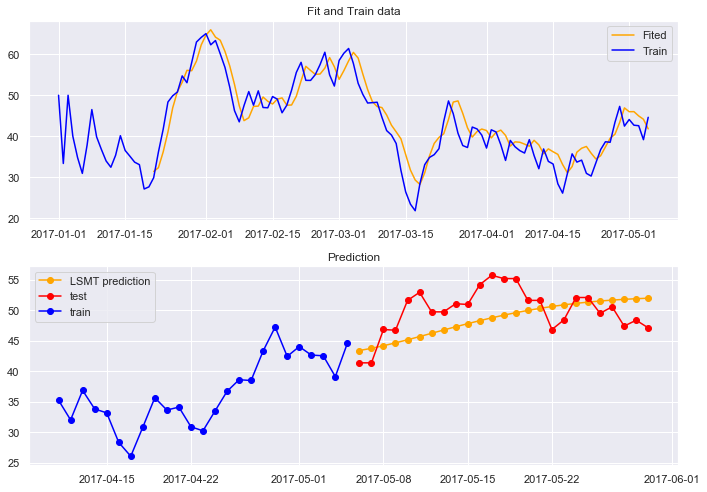

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,7))

axes[0].plot(fitted,color='orange',label='Fited')
axes[0].plot(Train,color='blue',label='Train')
axes[0].legend()
axes[0].title.set_text('Fit and Train data')

axes[1].plot(predictions_LSTM,label='LSMT prediction',color='orange',marker='o')
axes[1].plot(Test,label='test',color='red',marker='o')
axes[1].plot(Train[100:],label='train',color='blue',marker='o')
axes[1].legend()
axes[1].title.set_text('Prediction')

plt.tight_layout()
plt.savefig('plot_tesis14.jpg')
plt.show()

In [56]:
#expanding window prediction
predictions=[]
history_list=list(Train_scaled)
input_to_predict=np.array(history_list[-n_inputs:]).reshape((1,n_inputs,1))

for i in range(len(Test)):
    pred=model.predict(input_to_predict)
    pred=float(scaler.inverse_transform(pred))
    predictions.append(pred)
    obs=list(np.ravel(Test_scaled))[i]
    history_list.append(obs)
    input_to_predict=np.array(history_list[-n_inputs:]).reshape((1,n_inputs,1))
rolling_predictions_LSTM=np.array(predictions).reshape(len(predictions),1)
rolling_predictions_LSTM=pd.DataFrame(rolling_predictions_LSTM,index=Test.index,columns=['predictions_LSTM'])

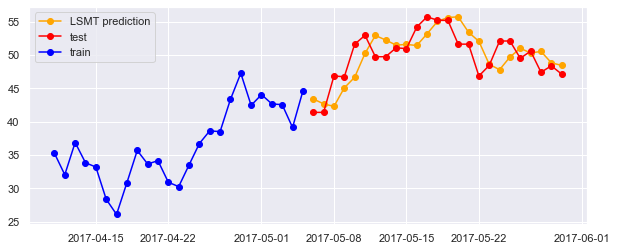

In [57]:
plt.figure(figsize=(10,4))
plt.plot(rolling_predictions_LSTM,label='LSMT prediction',color='orange',marker='o')
plt.plot(Test,label='test',color='red',marker='o')
plt.plot(Train[100:],label='train',color='blue',marker='o')

plt.savefig('plot_tesis15.jpg')
plt.legend()


### Summary

In [58]:
l1=(Test.value.to_frame())
l2=rolling_predictions_HW_tunned
l3=predictions_rolling_arima_tunned
l4=rolling_predictions_SVR_tunned
l5=rolling_predictions_LSTM

summ_predictions=pd.concat([l1,l2,l3,l4,l5], axis=1, sort=False)
summ_predictions.head()

,value,rolling_predictions_HW,predictions_y_arima,rolling_predictions_SVR,predictions_LSTM
2017-05-06,41.406902,40.028073,45.785773,45.105469,43.431095
2017-05-07,41.406902,42.564549,40.841080,42.297060,42.683514
2017-05-08,46.876336,38.819941,42.260850,42.239433,42.306858
2017-05-09,46.755550,43.975610,47.934406,47.481181,45.089390
2017-05-10,51.642392,53.230209,48.407451,47.633054,46.681072


In [59]:
list_metric=['MAE_HW','MAE_arima','MAE_SVR','MAE_LSMT']
list_error=[mean_absolute_error(summ_predictions.value, summ_predictions.rolling_predictions_HW),
           mean_absolute_error(summ_predictions.value, summ_predictions.predictions_y_arima),
            mean_absolute_error(summ_predictions.value, summ_predictions.rolling_predictions_SVR),
            mean_absolute_error(summ_predictions.value, summ_predictions.predictions_LSTM)]

df_errors=pd.DataFrame(data=list_error,index=list_metric)
df_errors.rename(columns={0:'value'}).transpose()

,MAE_HW,MAE_arima,MAE_SVR,MAE_LSMT
value,2.162844,2.458856,2.246722,2.178928
